In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from collections import Counter, OrderedDict
import itertools
import string
import re

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import ReduceLROnPlateau

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import wordpunct_tokenize
from nltk.stem.lancaster import LancasterStemmer

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /home/stefano/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/stefano/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data augmentation
### Carichiamo il dataset

In [3]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
test_labels = pd.read_csv('dataset/test_labels.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
test_combined = pd.merge(test, test_labels, on=['id'])

# Now remove -1 and 0 values
test = test_combined[(test_combined.toxic == 1) | (test_combined.severe_toxic == 1) |
                      (test_combined.obscene == 1) | (test_combined.threat == 1) | (test_combined.insult == 1) |
                      (test_combined.identity_hate == 1)]

In [5]:
# Extract Labels
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
test_labels = test[list_classes].values

# Convert to lower-case all words
text = test.comment_text
test.comment_text = list(map(lambda x: x.lower(), text))

/home/stefano/.local/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


### Text preprocessing

In [6]:
# Prepare the datasets:
# Shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)

# Extract Labels
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
labels = train[list_classes].values

# Convert to lower-case all words
text = train.comment_text
train.comment_text = list(map(lambda x: x.lower(), text))

## Per via della scarsa quantità di commenti severe_toxic e threat proviamo ad performare una data_augmentation di questo tipo di commenti. Salviam i commenti etichettati come threat e severe toxic a parte. Li utilizzeremo successivamente.

In [7]:
threat_severe_comments = train[(train.severe_toxic == 1) | (train.threat == 1)]

# Mi salvo le label in modo tale dopo da riutilizzare per i commenti artificiali
# Ogni commento artificiale creato da un sample dovrà avere ovviamente le stese label
save_labels = threat_severe_comments[list_classes].values

In [8]:
# Remove contractions

contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

# De-contract words
def clean(text):
  text = text.split(" ")
  new_text = []
  for word in text:
    if word in contractions:
      new_text.append(contractions[word])
    else:
      new_text.append(word)
  text = " ".join(new_text)
  return text

In [9]:
#Augmentation
clean_text = []
for text in threat_severe_comments.comment_text:
   clean_text.append(clean(text))

threat_severe_comments.comment_text = clean_text

augmentation_text = list(threat_severe_comments.comment_text)

#Train
clean_text = []
for text in train.comment_text:
   clean_text.append(clean(text))

train.comment_text = clean_text

train_text = list(train.comment_text)

#Test
clean_text = []
for text in test.comment_text:
   clean_text.append(clean(text))

test.comment_text = clean_text

test_text = list(test.comment_text)

In [10]:
# Addtional cleaning with RegEx and StopWords
stop = stopwords.words('english')
# Let's add some new stopwords
stop = set(stop)
stop.remove("not")
stop.add("d'aww")
stop.add("\n")
stop.add("''")
stop.add("``")
stop.add("'s")
stop.add("...")
stop.add("p.s")

#Augmentation
for i in range(0,len(augmentation_text)):
    augmentation_text[i] = re.sub(r'[^\w\s]','', augmentation_text[i])
    text = augmentation_text[i].split()
    output = ""
    for word in text:
        if word not in stop:
            output = output + " " + word
    output = output.strip().replace("  ", " ")
    augmentation_text[i] = output

augmentation_text[0:5]

#Train
for i in range(0,len(train_text)):
    train_text[i] = re.sub(r'[^\w\s]','', train_text[i])
    text = train_text[i].split()
    output = ""
    for word in text:
        if word not in stop:
            output = output + " " + word
    output = output.strip().replace("  ", " ")
    train_text[i] = output

train_text[0:5]

#Test
for i in range(0,len(test_text)):
    test_text[i] = re.sub(r'[^\w\s]','', test_text[i])
    text = test_text[i].split()
    output = ""
    for word in text:
        if word not in stop:
            output = output + " " + word
    output = output.strip().replace("  ", " ")
    test_text[i] = output

test_text[0:5]

['arabs committing genocide iraq protests europe may europe also burn hell',
 'dj robinson gay hell sucks dick much',
 'fuck antisemitic cunt',
 'dare vandalize page hms beagle not vandalize demon',
 'arrogant self serving immature idiot get right']

## Divisione in Train e Validation. Le frasi artificiali generate verranno aggiunte solo al Train

In [11]:
#Splitting in train e validation. Le frasi artificiali che verranono create saranno aggiunte
#solo al train
train_text_splitted, validation_text, train_labels_splitted, validation_labels = train_test_split(train_text, labels, test_size=0.3, random_state=42)

In [12]:
# Tokenize using keras.preprocess: it will remove also the punctuation
MAX_WORDS = 200000
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(train_text)
tokenized_text = tokenizer.texts_to_sequences(train_text)
word_indeces = tokenizer.word_index

In [13]:
MAX_LENGTH = 200 
padded_text = pad_sequences(tokenized_text, padding='post', maxlen=MAX_LENGTH)

In [14]:
padded_text

array([[ 4939,     2, 39083, ...,     0,     0,     0],
       [   64,  2993,  3781, ...,     0,     0,     0],
       [   27,    60,    33, ...,     0,     0,     0],
       ...,
       [  376,     2, 38816, ...,     0,     0,     0],
       [  937,   992,  1257, ...,     0,     0,     0],
       [ 3478,   139,  1323, ..., 16170,   199,   366]], dtype=int32)

### E' il momento di applicare GLOVe

In [15]:
# Load Glove data
GLOVE_PATH = "dataset/glove.6B/glove.6B.200d.txt"
embeddings_index = {}
f = open(GLOVE_PATH)
print("Loading..")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word]=np.asarray(values[1:], dtype="float32")
f.close()
print("Loaded!")

Loading..
Loaded!


In [16]:
# Create the embedded matrix
embedding_matrix = np.random.random((len(word_indeces) +1, 200))
for word, i in word_indeces.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Cerchiamo ora di creare una matrice NearsetNeighbors con cui andremo a creare delle frasi artificiali.

In [17]:
from sklearn.neighbors import NearestNeighbors

synonyms_number = 5
word_number = 20000

In [18]:
#Creazione della neighbour matrix che andreo ad utilizzare sucessivamente

#!!!!!!!!!!!!!! QUESTA OPERAZIONE PUÒ RICHIEDERE PIÙ DI 30 MINUTI DI ESECUZIONE !!!!!!!!!!!!!!!!!
nn = NearestNeighbors(n_neighbors=synonyms_number+1).fit(embedding_matrix)

neighbours_mat = nn.kneighbors(embedding_matrix[1:word_number])[1]

In [19]:
#Per risparmiare tempo è stato provato a salvare la matrice e caricarla.
#Questo però portava ad errori quindi è preferibile crearla ogni volta

#np.save('neigh_mat_final', neighbours_mat)
#neighbours_mat = np.load('neigh_mat_final.npy')

In [21]:
index_word = {0: ''}
for word in tokenizer.word_index.keys():
    index_word[tokenizer.word_index[word]] = word

In [22]:
synonyms = {x[0]: x[1:] for x in neighbours_mat}

## WordCloud dei sinonimi trovati

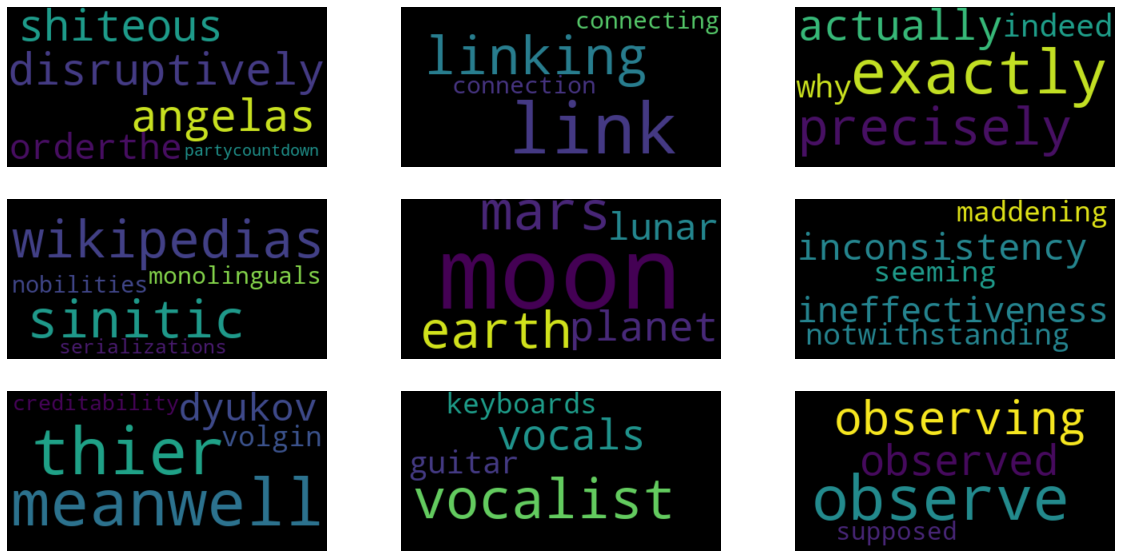

In [23]:
index = np.random.randint(1, word_number, 9)
plt.figure(figsize=(20,10))

for k in range(len(index)):
    plt.subplot(3, 3, k+1)
    
    x = index[k]
    text = ' '.join([index_word[x]] + [index_word[synonyms[x][i]] for i in range(synonyms_number-1)]) 
    wordcloud = WordCloud(stopwords=[]).generate((text))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

### Creiamo una funzione da andare ad utilizzare per generare le frasi artificiali.

In [24]:
def modify_sentence(sentence, synonyms, p = 0.5):
    for i in range(len(sentence)):
        if np.random.random() > p:
            try:
                syns = synonyms[sentence[i]]
                sentence[i] = np.random.choice(syns)
            except KeyError:
                pass
    return sentence

In [25]:
#Elimino la colonna degli id per poter aggiungere i nuovi commenti artificiali
train = train.drop(train.columns[0], axis=1)

In [26]:
#Applying padding to augmentation_text
tokenized_augmentation_text = tokenizer.texts_to_sequences(augmentation_text)

padded_augmentation_text = pad_sequences(tokenized_augmentation_text, padding='post', maxlen=MAX_LENGTH)

### Vado a creare i commenti artificiali. Ai commenti generati andrò ad appendere le labels del commento originale da cui sto generando la frase.

In [27]:
artificial_comments = []
i = 0

for x in padded_augmentation_text:
    sample =  np.trim_zeros(x)
    sentence = ' '.join([index_word[x] for x in sample])
    print(sentence)

    modified = modify_sentence(sample, synonyms)
    sentence_m = ' '.join([index_word[x] for x in modified])
    print(sentence_m)
    
    aux = []
    aux.append(sentence_m)
    for label in save_labels[i]:
        aux.append(label)
    artificial_comments.append(aux)
    
    modified2 = modify_sentence(sample, synonyms)
    sentence_m2 = ' '.join([index_word[x] for x in modified2])
    print(sentence_m2)
    
    aux = []
    aux.append(sentence_m2)
    for label in save_labels[i]:
        aux.append(label)
    artificial_comments.append(aux)
        
    i += 1
    print(' ')

knock vandlism report fucking dumass
bounce vandlism findings fucking dumass
bounce vandlism findings fuckin dumass
 
shut whore mouth open letter wikipedia review message beam fuck think place waltz unannounced received arms wide open well fuck motherfucking wikipedia bitch call shots always get shotgun not give fuck infinitely important always first line always fuck hot chick gets acne settles rob banks charities anyone else fucking pisses us place place faggot ideology ideology says need get fuck one ever like already established cliques slopworthyhoes propworthybros got ideology elitism exploitation lulz not fucking game kid not try tag along talking people around block pioneered class made cool cool done jerked shower invented jerking shower stupid bitch clearcut defined infinitely thick wall us built wall keeps fags not try act like know fuck going dont not really think compete review lol wow not make start flaming forgetting ones film people like getting fucking destroyed us rip

In [28]:
len(artificial_comments)

3922

### Preparo il dataframe in cui andrò ad inserire i commenti artificiali, che verranno successivamente uniti ai dati di train orginali.

In [29]:
# Preparing columns for new_df artificial comments
col = ['comment_text']

for label in list_classes:
    col.append(label)
    
new_comments = pd.DataFrame(artificial_comments, columns = col) 

In [30]:
# Preparing columns for new_train
datas = []
for comment, labels in zip(train_text_splitted, train_labels_splitted):
    new_row = []
    new_row.append(comment)
    for label in labels:
        new_row.append(label)
    datas.append(new_row)
    
col = ['comment_text']

for label in list_classes:
    col.append(label)
    
new_train = pd.DataFrame(datas, columns = col) 

### Shuffling del dataset finale

In [32]:
new_train = new_train.append(new_comments)
new_train = new_train.sample(frac=1).reset_index(drop=True)

In [33]:
labels = new_train[list_classes].values

In [34]:
text = new_train.comment_text
new_train.comment_text = list(map(lambda x: x.lower(), text))

clean_text = []

for text in new_train.comment_text:
   clean_text.append(clean(text))

new_train.comment_text = clean_text

new_train_text = list(new_train.comment_text)

for i in range(0,len(new_train_text)):
    new_train_text[i] = re.sub(r'[^\w\s]','', new_train_text[i])
    text = new_train_text[i].split()
    output = ""
    for word in text:
        if word not in stop:
            output = output + " " + word
    output = output.strip().replace("  ", " ")
    new_train_text[i] = output

In [35]:
#Creazione dei testi paddati per test,train e validation
tokenized_test_text = tokenizer.texts_to_sequences(test_text)
padded_test_text = pad_sequences(tokenized_test_text, padding='post', maxlen=MAX_LENGTH)

tokenized_text = tokenizer.texts_to_sequences(new_train_text)
padded_text = pad_sequences(tokenized_text, padding='post', maxlen=MAX_LENGTH)

tokenized_validation_text = tokenizer.texts_to_sequences(validation_text)
padded_validation_text = pad_sequences(tokenized_validation_text, padding='post', maxlen=MAX_LENGTH)

In [66]:
# Apply the embedded matrix to our tokens
sequence_input = Input(shape=(200,), dtype='int32')
embedding_layer = Embedding(len(word_indeces) + 1,
                           200,
                           weights = [embedding_matrix],
                           input_length = 200,
                           trainable=False,
                           name = 'embeddings')
embedded = embedding_layer(sequence_input)

In [67]:
layer = Flatten(name='flatten')(embedded)
layer = Dense(100, activation="relu", name='hidden_1')(layer)
#layer = Dropout(0.3)(layer)
layer = Dense(50, activation="relu", name='hidden_2')(layer)
output = Dense(6, activation="sigmoid", name='output')(layer)
model = Model(sequence_input, output)

In [68]:
opt = tf.keras.optimizers.Adam(learning_rate=0.005, amsgrad=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

fBestModel = 'best_model_augmentation.h5' 
best_model = tf.keras.callbacks.ModelCheckpoint(fBestModel, 
                                                monitor='val_fmeasure', 
                                                verbose=1, 
                                                save_best_only=True,
                                                mode='max')

In [69]:
from tensorflow.keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def fmeasure(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [70]:
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy', fmeasure])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 200)          50538200  
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0         
_________________________________________________________________
hidden_1 (Dense)             (None, 100)               4000100   
_________________________________________________________________
hidden_2 (Dense)             (None, 50)                5050      
_________________________________________________________________
output (Dense)               (None, 6)                 306       
Total params: 54,543,656
Trainable params: 4,005,456
Non-trainable params: 50,538,200
_______________________________________

In [52]:
tf.keras.utils.plot_model(model,rankdir='LR')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [71]:
print("Fase di training")
history = model.fit(padded_text, labels, epochs = 18, batch_size = 256, 
                    validation_data = (padded_validation_text, validation_labels), callbacks=[learning_rate_reduction, best_model])

Fase di training
Train on 115621 samples, validate on 47872 samples
Epoch 1/18
115456/115621 [============================>.] - ETA: 0s - loss: 0.6133 - acc: 0.9417 - fmeasure: 0.3129
Epoch 00001: val_fmeasure improved from -inf to 0.40792, saving model to best_model_augmentation.h5
115621/115621 [==============================] - 46s 397us/sample - loss: 0.6126 - acc: 0.9417 - fmeasure: 0.3130 - val_loss: 0.0927 - val_acc: 0.9697 - val_fmeasure: 0.4079
Epoch 2/18
115456/115621 [============================>.] - ETA: 0s - loss: 0.1125 - acc: 0.9610 - fmeasure: 0.5604
Epoch 00002: val_fmeasure improved from 0.40792 to 0.53409, saving model to best_model_augmentation.h5
115621/115621 [==============================] - 43s 372us/sample - loss: 0.1125 - acc: 0.9610 - fmeasure: 0.5606 - val_loss: 0.0837 - val_acc: 0.9720 - val_fmeasure: 0.5341
Epoch 3/18
115456/115621 [============================>.] - ETA: 0s - loss: 0.1034 - acc: 0.9636 - fmeasure: 0.6077
Epoch 00003: val_fmeasure did not

In [72]:
# Now we load the weights obtained in the lowest validation loss configuration
model.load_weights('best_model_augmentation.h5')

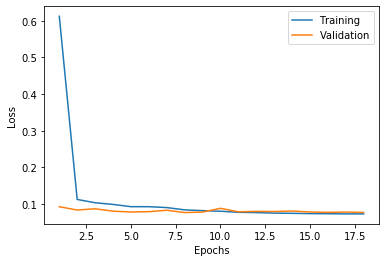

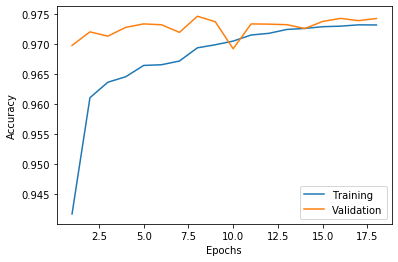

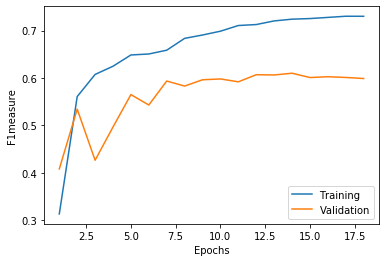

In [73]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['acc'])
    plt.plot(x_plot, network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('F1measure')
    plt.plot(x_plot, network_history.history['fmeasure'])
    plt.plot(x_plot, network_history.history['val_fmeasure'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

# Show the plots
x_plot = list(range(1,19)) #cambio con batch+1
plot_history(history)

### Valutiamo ora le performance sul test composto da soli toxic comments

In [74]:
from sklearn.metrics import classification_report
     
y_pred = np.round(model.predict(padded_test_text))
c = classification_report(test_labels, y_pred, target_names=list_classes)
print(c)

               precision    recall  f1-score   support

        toxic       0.98      0.64      0.78      6090
 severe_toxic       0.18      0.56      0.27       367
      obscene       0.81      0.61      0.69      3691
       threat       0.48      0.18      0.26       211
       insult       0.71      0.58      0.64      3427
identity_hate       0.63      0.17      0.27       712

    micro avg       0.77      0.59      0.67     14498
    macro avg       0.63      0.46      0.48     14498
 weighted avg       0.83      0.59      0.68     14498
  samples avg       0.52      0.54      0.50     14498



In [46]:
from sklearn.metrics import precision_recall_fscore_support
score = precision_recall_fscore_support(test_labels, y_pred, average='micro')
print('Micro avg: ', score)
score = precision_recall_fscore_support(test_labels, y_pred, average=None)
for i in range(0,len(list_classes)):
    print('Classe: ',i) 
    print('Precision ',score[0][i])
    print('Recall ', score[1][i])
    print('F1 ', score[2][i])

Micro avg:  (0.7944091990483743, 0.5527658987446544, 0.6519157243959977, None)
Classe:  0
Precision  0.9855513307984791
Recall  0.638423645320197
F1  0.7748878923766817
Classe:  1
Precision  0.2084130019120459
Recall  0.5940054495912807
F1  0.3085633404104742
Classe:  2
Precision  0.8101972459992557
Recall  0.5898130587916554
F1  0.6826591407964879
Classe:  3
Precision  0.0
Recall  0.0
F1  0.0
Classe:  4
Precision  0.7240356083086054
Recall  0.49839509775313684
F1  0.5903905979951608
Classe:  5
Precision  0.46
Recall  0.032303370786516857
F1  0.060367454068241476


### Dai risultati emerge chiaramente come il modello con Oversampling sia stato in grado di migliorare in modo considerevole il f1score sulla classe Threat, che nel primo modello aveva ottenuto 0%.

### La Recall delle classi in esame ha subito un miglioramento, a discapito della Precision sulla Classe Severe_Toxic.

### Concludendo, è necessario provare una tecnica di rappresentazione testuale differente per andare migliorare il valore di F1 micro avg.